# Используемые библиотеки

In [1]:
import gc # сборщик мусора

import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns
%matplotlib inline
import numpy as np 
import pandas as pd 

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error as mse, r2_score as r2

from lightgbm import LGBMRegressor

# https://www.kaggle.com/camnugent/geospatial-feature-engineering-and-visualization

1) Выгрузка данных
2) Работа с данными
3) Обучение и тренировка
4) Обучение финальной модели

# Функции, используемые в коде

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
def nan_analize(X):
    nan_df = (X.isna().sum() / X.shape[0]).reset_index()
    nan_df.columns=['feature', 'nan_percent']

    plt.figure(figsize=(16,4))
    sns.barplot(nan_df['feature'], nan_df['nan_percent'])
    plt.title('Percent Missing')
    plt.ylabel('Missing', fontsize=12)
    plt.xlabel('Features', fontsize=12)
    plt.xticks(rotation=90)
    plt.show()

In [4]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 5)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

In [5]:
def plot_feature_importances(importances, X):
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize = (20, 6))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X.shape[1]), importances[indices] / importances.sum(),
           color="darkblue", align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation = 90, fontsize=14)
    plt.xlim([-1, X.shape[1]])

    plt.tight_layout()
    # plt.savefig('fe.jpg')
    plt.show()

In [6]:
def distance(cordinate):
    a, b, c = 1, 0.937, 86.417
    return abs(a*cordinate['longitude'] + b*cordinate['latitude'] + c) / ((a**2 + b**2) ** (1 / 2))

In [7]:
def distance_final(cordinate):
    a, b, c = 1, 0.955, 85.792
    return abs(a*cordinate['longitude'] + b*cordinate['latitude'] + c) / ((a**2 + b**2) ** (1 / 2))

# Загрузка данных

In [8]:
df = pd.read_csv('Data set to train.csv')
df.head(10)

,Id,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
0,5088,-118.28,33.98,19.0,883.0,313.0,726.0,277.0,0.9809,<1H OCEAN,121400.0
1,17096,-122.23,37.46,33.0,2643.0,464.0,1015.0,427.0,4.2232,NEAR OCEAN,363700.0
2,5617,-118.26,33.79,42.0,1162.0,264.0,1044.0,241.0,3.5488,<1H OCEAN,205600.0
3,20060,-119.26,35.87,24.0,1590.0,390.0,1686.0,372.0,1.6469,INLAND,47600.0
4,895,-121.96,37.54,14.0,5106.0,1207.0,2738.0,1108.0,3.9909,<1H OCEAN,236000.0
5,19653,-120.85,37.49,39.0,2840.0,733.0,2606.0,737.0,1.9429,INLAND,76400.0
6,18403,-121.84,37.24,24.0,7991.0,1286.0,4017.0,1213.0,5.4741,<1H OCEAN,238800.0
7,11307,-117.94,33.78,40.0,299.0,68.0,163.0,70.0,3.0125,<1H OCEAN,166100.0
8,1225,-120.43,38.25,13.0,763.0,161.0,311.0,125.0,2.4583,INLAND,112500.0
9,6408,-118.03,34.13,33.0,2352.0,373.0,995.0,359.0,4.9583,INLAND,445700.0


In [9]:
df.columns

Index(['Id ', 'longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity', 'median_house_value'],
      dtype='object')

In [10]:
X = df.drop('median_house_value', axis=1)
y = df[['Id ', 'median_house_value']]

X.set_index('Id ', inplace=True)
y.set_index('Id ', inplace=True)

In [11]:
X_final = pd.read_csv('Data set to test X.csv')
X_final.set_index('Id ', inplace=True)
final_index_list = X_final.index

In [12]:
print('Строк в трейне:' ,  X.shape[0])
print('Строк в тесте', X_final.shape[0])

Строк в трейне: 13828
Строк в тесте 6812


In [13]:
X = reduce_mem_usage(X)

Memory usage of dataframe is 1.05 MB
Memory usage after optimization is: 0.33 MB
Decreased by 68.7%


In [14]:
X_final = reduce_mem_usage(X_final)

Memory usage of dataframe is 0.52 MB
Memory usage after optimization is: 0.16 MB
Decreased by 68.7%


# Смотрим данные (EDA)

**Описание датасета**

Статистические данные о ряде домов в Калифорнии, основанные на переписи 1990 года.

* **longitude** - долгота
* **latitude** - широта
* **housing_median_age** - средний возраст дома
* **total_rooms** - общее количество комнат
* **total_bedrooms** - общее количество спален
* **population** - количество проживающих
* **households** - домохозяйства
* **ocean_proximity** - близость океана
* **median_income** - средний доход
* **median_house_value** - средняя стоимость дома

In [15]:
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
Id,,,,,,,,,
5088,-118.2500,33.96875,19.0,883.0,313.0,726.0,277.0,0.980957,<1H OCEAN
17096,-122.2500,37.46875,33.0,2644.0,464.0,1015.0,427.0,4.222656,NEAR OCEAN
5617,-118.2500,33.78125,42.0,1162.0,264.0,1044.0,241.0,3.548828,<1H OCEAN
20060,-119.2500,35.87500,24.0,1590.0,390.0,1686.0,372.0,1.646484,INLAND
895,-121.9375,37.53125,14.0,5104.0,1207.0,2738.0,1108.0,3.990234,<1H OCEAN


In [16]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13828 entries, 5088 to 15795
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           13828 non-null  float16 
 1   latitude            13828 non-null  float16 
 2   housing_median_age  13349 non-null  float16 
 3   total_rooms         13828 non-null  float16 
 4   total_bedrooms      13828 non-null  float16 
 5   population          13429 non-null  float16 
 6   households          13828 non-null  float16 
 7   median_income       13828 non-null  float16 
 8   ocean_proximity     13828 non-null  category
dtypes: category(1), float16(8)
memory usage: 337.8 KB


In [17]:
X.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'],
      dtype='object')

In [18]:
X.shape

(13828, 9)

## Количественные переменные

In [19]:
X.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,1.382800e+04,13828.00000,1.334900e+04,13828.0,13828.0,13429.0,13828.0,13828.000000
mean,-inf,inf,inf,inf,inf,inf,inf,3.876953
std,4.859375e+00,inf,1.257812e+01,inf,inf,inf,inf,1.903320
min,-1.243750e+02,-13536.00000,1.000000e+00,2.0,1.0,3.0,1.0,0.500000
25%,-1.218125e+02,33.93750,1.800000e+01,1455.0,297.0,791.0,280.0,2.568359
50%,-1.185000e+02,34.28125,2.900000e+01,2140.0,437.0,1168.0,412.0,3.539062
75%,-1.180000e+02,37.71875,3.700000e+01,3166.0,648.0,1732.0,607.0,4.757812
max,1.213125e+02,1327.00000,5.200000e+01,32624.0,6444.0,35680.0,6080.0,15.000000


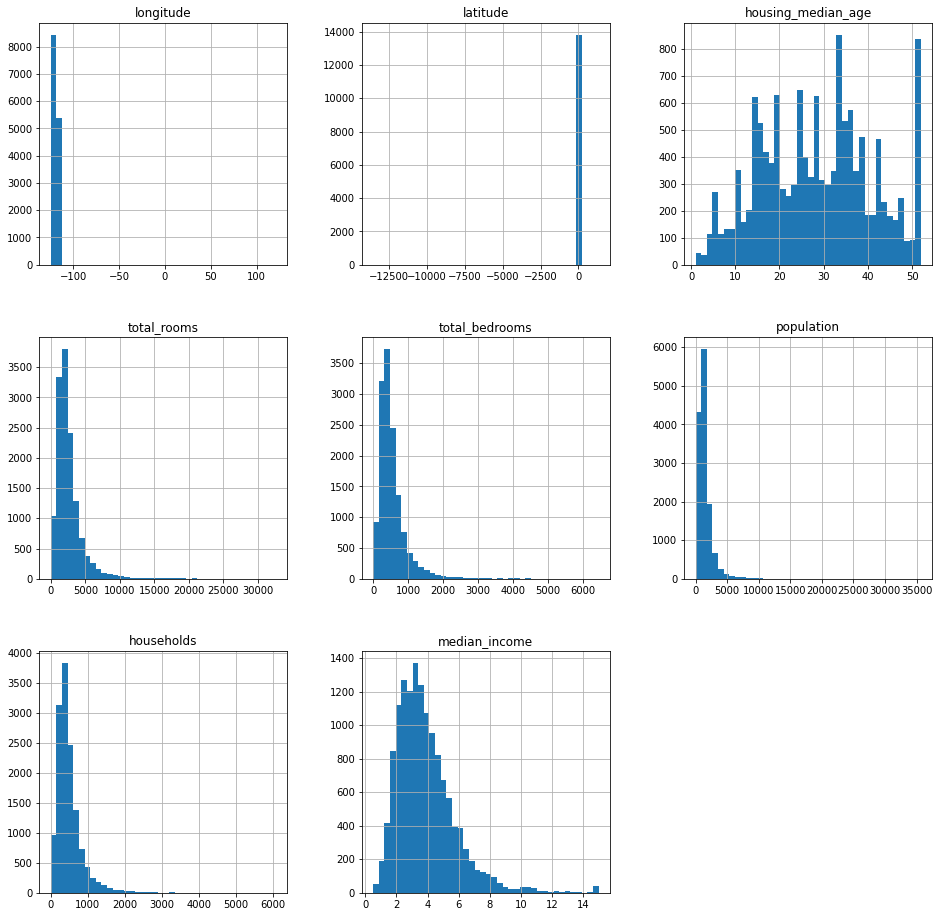

In [20]:
X.hist(figsize=(16,16), bins=40);

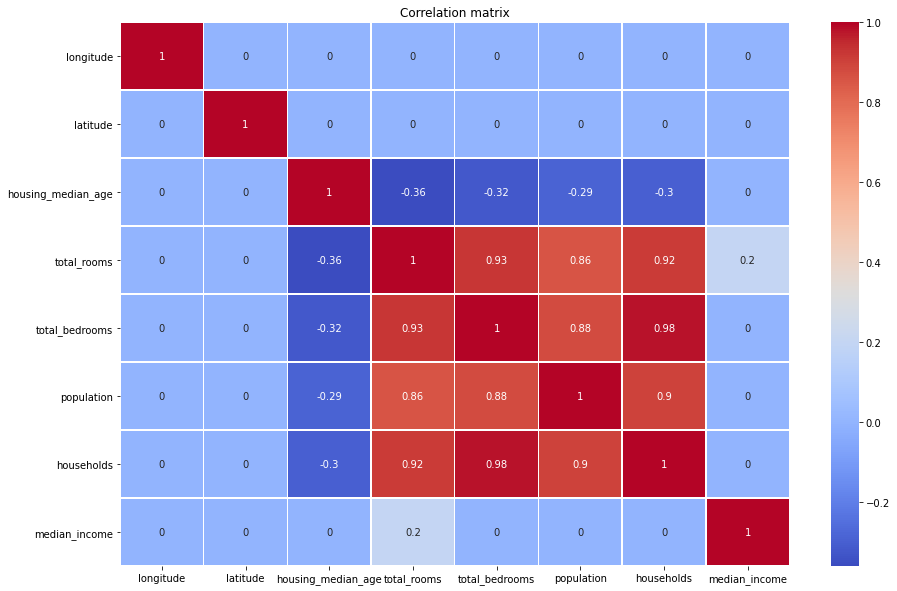

In [21]:
plt.figure(figsize = (15,10))

corr_matrix = X.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.2] = 0  # Проверьте, что будет если убрать маленькие корреляции

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

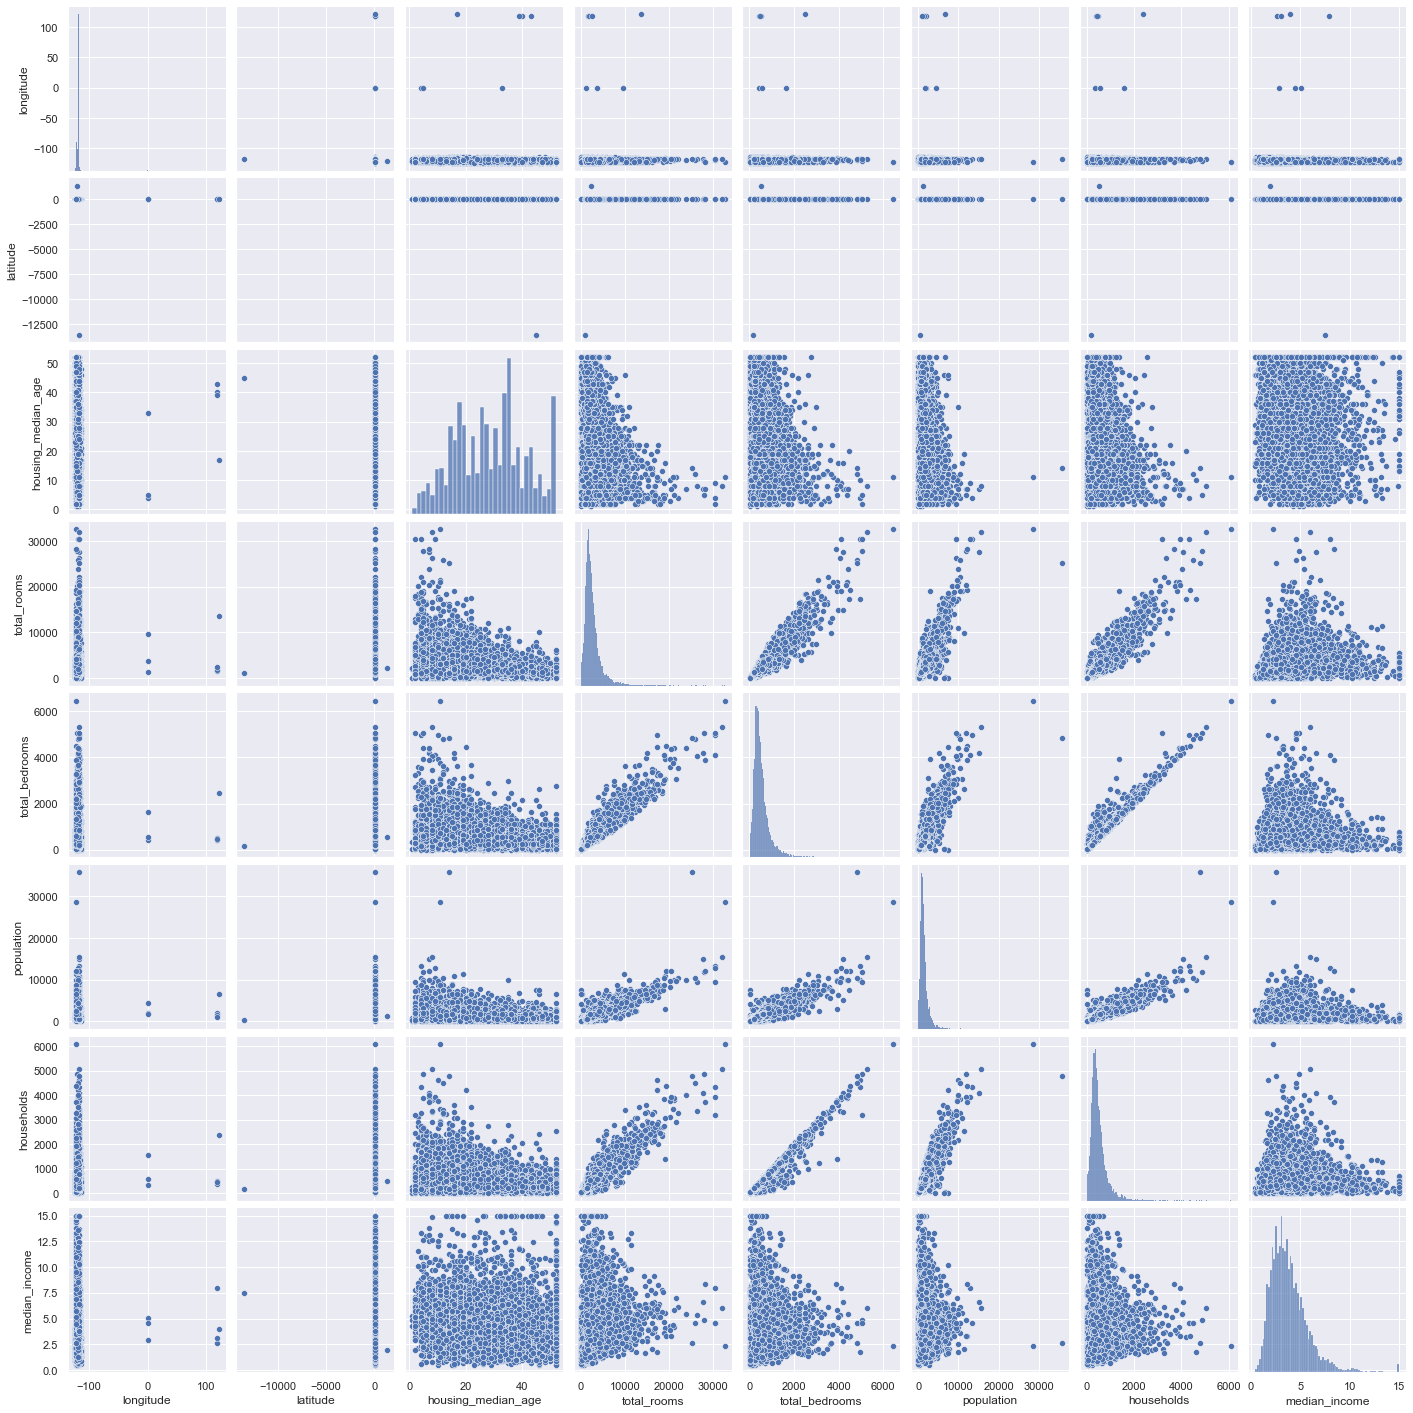

In [22]:
sns.set()
sns.pairplot(X, height = 2.5)
plt.show()

median_income         0.688368
total_rooms           0.135491
housing_median_age    0.108228
Id                    0.069206
households            0.064990
total_bedrooms        0.050051
longitude            -0.017639
latitude             -0.020219
population           -0.023777
Name: median_house_value, dtype: float64


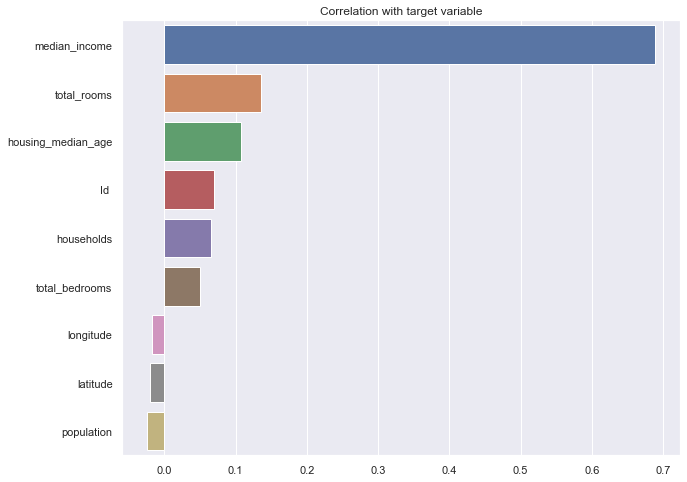

In [23]:
corr_with_target = df.corr().iloc[:-1, -1].sort_values(ascending=False)
print(corr_with_target)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

## Качественные переменные

In [24]:
X['ocean_proximity'].value_counts()

<1H OCEAN     6144
INLAND        4414
NEAR OCEAN    1702
NEAR BAY      1552
-               13
ISLAND           3
Name: ocean_proximity, dtype: int64

In [25]:
base_features = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity']

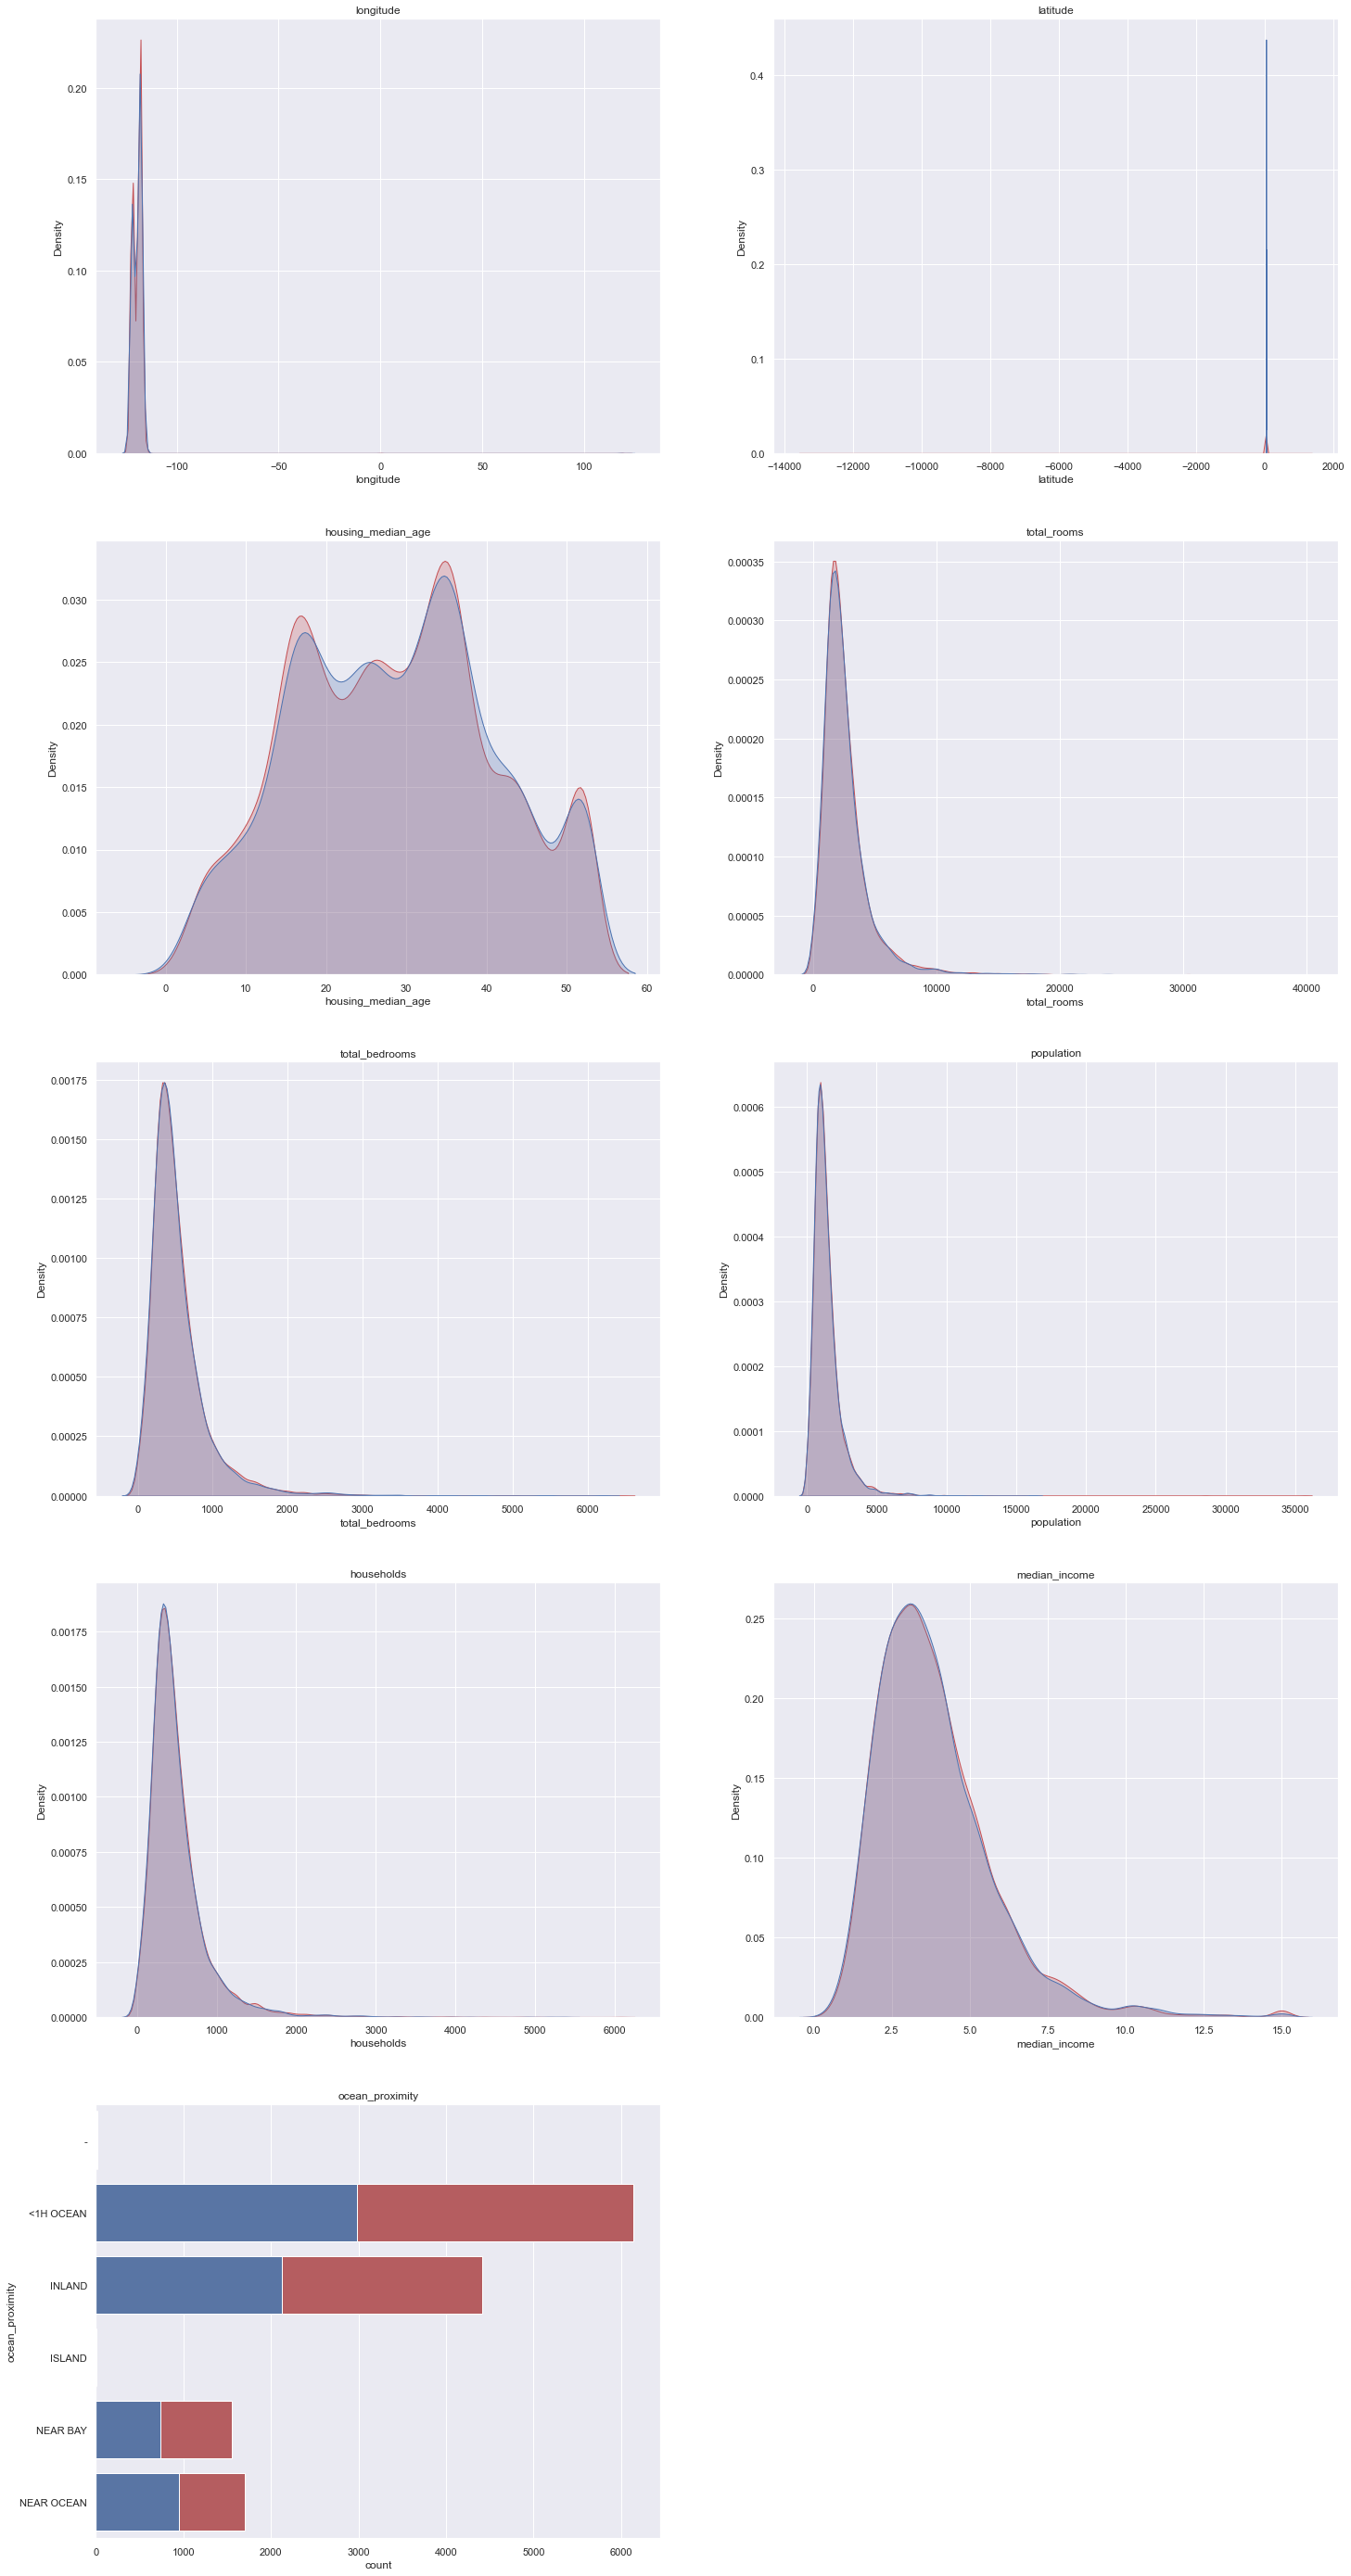

In [26]:
plt.figure(figsize = (24, 50))

l = len(base_features)

for i in range(l):
    plt.subplot((l+1)//2,2,i+1)
    plt.title(base_features[i])
    if X[base_features[i]].dtype == 'float16':
        sns.kdeplot(X[base_features[i]], shade=True, label='train', color='r')
        sns.kdeplot(X_final[base_features[i]], shade=True, label='test', color='b')
    else:
        sns.countplot(y=base_features[i], data=X, color = 'r')
        sns.countplot(y=base_features[i], data=X_final, color = 'b')

plt.show()

# Анализируем и исправляем

1) исправляем выбросы в lantitude

In [27]:
X[(X['latitude'] < 32) | (X['latitude'] > 42)]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
Id,,,,,,,,,
8283,-118.1250,-13536.0,45.0,1016.0,172.0,361.0,163.0,7.500000,NEAR OCEAN
12772,-121.4375,1327.0,NaN,2216.0,536.0,1203.0,507.0,1.941406,INLAND


In [28]:
X = X.sort_index()
y = y.sort_index()
X_final = X_final.sort_index()

In [29]:
X.loc[8280:8288]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
Id,,,,,,,,,
8281,-118.125,33.78125,35.0,2768.0,752.0,1277.0,651.0,3.619141,NEAR OCEAN
8282,-118.125,33.78125,42.0,1898.0,488.0,940.0,483.0,3.410156,NEAR OCEAN
8283,-118.125,-13536.00000,45.0,1016.0,172.0,361.0,163.0,7.500000,NEAR OCEAN
8286,-118.125,33.78125,52.0,2204.0,498.0,899.0,445.0,4.175781,NEAR OCEAN
8287,-118.125,33.78125,NaN,3448.0,896.0,1621.0,838.0,4.500000,NEAR OCEAN


In [30]:
X.loc[8283, 'latitude'] = 33.78

In [31]:
X.loc[12765:12780]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
Id,,,,,,,,,
12765,-121.4375,38.62500,21.0,3260.0,763.0,1735.0,736.0,2.515625,INLAND
12766,-121.4375,38.62500,33.0,3172.0,832.0,1591.0,695.0,2.078125,INLAND
12768,-121.4375,38.62500,40.0,1134.0,252.0,675.0,249.0,1.369141,INLAND
12770,-121.4375,38.62500,42.0,1385.0,273.0,740.0,274.0,2.605469,INLAND
12771,-121.4375,38.62500,43.0,1009.0,225.0,604.0,218.0,1.664062,INLAND
12772,-121.4375,1327.00000,NaN,2216.0,536.0,1203.0,507.0,1.941406,INLAND
12773,-121.4375,38.62500,36.0,1765.0,438.0,1008.0,382.0,2.064453,INLAND
12775,-121.4375,38.62500,41.0,1578.0,317.0,897.0,333.0,2.322266,INLAND
12777,-121.4375,38.62500,42.0,1720.0,382.0,1069.0,362.0,1.861328,INLAND


In [32]:
X.loc[12772, 'latitude'] = 38.62500

2) исправляем выбросы в longitude

In [33]:
X[(X['longitude'] < -130) | (X['longitude'] > -110)]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
Id,,,,,,,,,
5904,118.4375,34.28125,39.0,1769.0,410.0,1499.0,390.0,3.121094,<1H OCEAN
8405,118.3750,33.93750,40.0,1625.0,500.0,2036.0,476.0,2.628906,<1H OCEAN
8636,118.4375,33.87500,43.0,2492.0,449.0,1033.0,437.0,7.960938,<1H OCEAN
13051,121.3125,38.62500,17.0,13552.0,2474.0,6544.0,2360.0,3.972656,INLAND
17085,0.0000,37.46875,33.0,1266.0,415.0,1991.0,334.0,2.919922,NEAR OCEAN
17359,0.0000,34.87500,4.0,3680.0,559.0,1678.0,569.0,5.062500,<1H OCEAN
19423,0.0000,37.68750,5.0,9600.0,1639.0,4448.0,1575.0,4.531250,INLAND


In [34]:
X_final[(X_final['longitude'] < -130) | (X_final['longitude'] > -110)]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
Id,,,,,,,,,
3479,118.50,34.28125,29.0,1287.0,194.0,525.0,187.0,6.417969,<1H OCEAN
15263,117.25,33.03125,21.0,2144.0,340.0,928.0,344.0,5.796875,NEAR OCEAN
18551,122.00,36.96875,28.0,1607.0,421.0,926.0,385.0,2.425781,NEAR OCEAN


In [35]:
X.loc[X['longitude'] > 0, 'longitude'] = - X.loc[X['longitude'] > 0, 'longitude'] 
X_final.loc[X_final['longitude'] > 0, 'longitude'] = - X_final.loc[X_final['longitude'] > 0, 'longitude'] 

In [36]:
X.loc[17080:17090]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
Id,,,,,,,,,
17080,-122.1875,37.46875,38.0,1300.0,269.0,608.0,292.0,4.558594,NEAR BAY
17081,-122.1875,37.46875,44.0,1371.0,263.0,589.0,301.0,4.808594,NEAR BAY
17082,-122.1875,37.46875,44.0,1927.0,332.0,846.0,362.0,4.207031,NEAR BAY
17083,-122.1875,37.46875,37.0,1053.0,266.0,939.0,267.0,3.199219,NEAR BAY
17085,0.0000,37.46875,33.0,1266.0,415.0,1991.0,334.0,2.919922,NEAR OCEAN
17086,-122.1875,37.46875,26.0,1777.0,555.0,1966.0,497.0,3.046875,NEAR OCEAN
17087,-122.1875,37.46875,43.0,733.0,162.0,497.0,175.0,3.271484,NEAR OCEAN
17089,-122.2500,37.46875,35.0,367.0,113.0,398.0,109.0,2.500000,NEAR OCEAN
17090,-122.2500,37.46875,28.0,5956.0,1612.0,3572.0,1549.0,3.185547,NEAR OCEAN


In [37]:
X.loc[17085, 'longitude'] = -122.1875

In [38]:
X.loc[17355:17360]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
Id,,,,,,,,,
17355,-120.4375,34.875,22.0,2580.0,381.0,1149.0,372.0,5.011719,<1H OCEAN
17356,-120.4375,34.875,18.0,2504.0,376.0,1162.0,382.0,4.835938,<1H OCEAN
17357,-120.4375,34.875,21.0,2132.0,329.0,1094.0,353.0,4.664062,<1H OCEAN
17358,-120.4375,34.875,26.0,1699.0,272.0,799.0,266.0,3.986328,<1H OCEAN
17359,0.0000,34.875,4.0,3680.0,559.0,1678.0,569.0,5.062500,<1H OCEAN
17360,-120.3750,34.875,10.0,2196.0,329.0,1064.0,319.0,4.976562,<1H OCEAN


In [39]:
X.loc[17359, 'longitude'] = -120.4062

In [40]:
X.loc[19420:19425]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
Id,,,,,,,,,
19420,-121.1875,37.62500,43.0,1244.0,209.0,611.0,197.0,2.875000,INLAND
19421,-121.0625,37.68750,7.0,9376.0,1847.0,4828.0,1722.0,3.462891,INLAND
19423,0.0000,37.68750,5.0,9600.0,1639.0,4448.0,1575.0,4.531250,INLAND
19424,-121.0000,37.71875,25.0,207.0,41.0,87.0,43.0,3.601562,INLAND
19425,-121.0000,37.68750,6.0,2608.0,557.0,1266.0,475.0,3.462891,INLAND


In [41]:
X.loc[19423, 'longitude'] = -121.0312

3) убираем дыры

c:\users\lukis\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


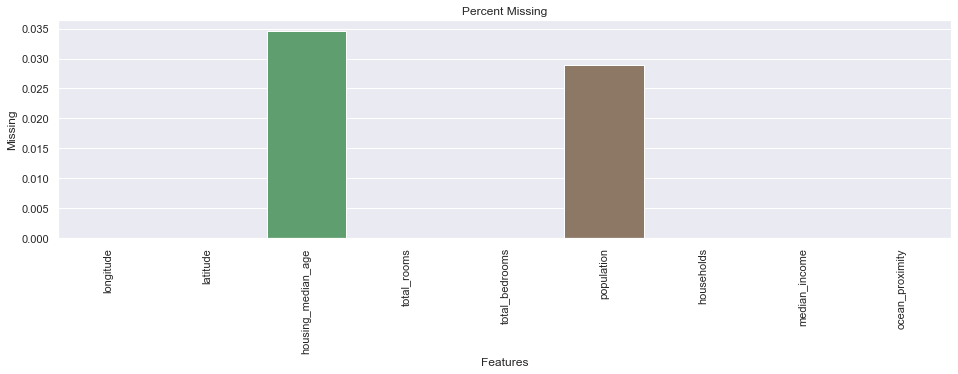

c:\users\lukis\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


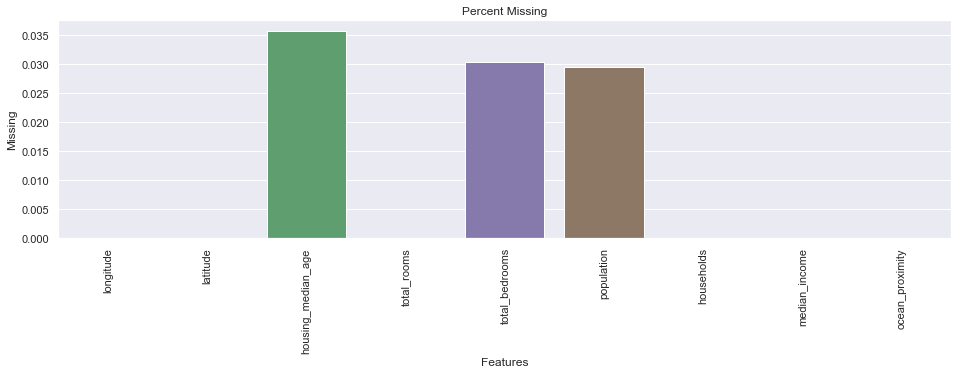

In [42]:
nan_analize(X)
nan_analize(X_final)

In [43]:
median = X['housing_median_age'].median()
X['housing_median_age'] = X['housing_median_age'].fillna(median)
X_final['housing_median_age'] = X_final['housing_median_age'].fillna(median)

In [44]:
median = X['population'].median()
X['population'] = X['population'].fillna(median)
X_final['population'] = X_final['population'].fillna(median)

4) переделываем качественные в количественные 

In [45]:
X = pd.concat([X, pd.get_dummies(X['ocean_proximity'])], axis=1)
X_final = pd.concat([X_final, pd.get_dummies(X_final['ocean_proximity'])], axis=1)

5) добавляем количество населения на комнату

In [46]:
X['population_per_room'] = X['population'] / X['total_rooms']
X_final['population_per_room'] = X_final['population'] / X_final['total_rooms']

In [47]:
X.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity', '-', '<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY',
       'NEAR OCEAN', 'population_per_room'],
      dtype='object')

6) добавляем расстояние до океана

In [48]:
X['distance'] = [distance(row) for index, row in X.loc[:, ['longitude', 'latitude']].iterrows()]
X_final['distance'] = [distance_final(row) for index, row in X_final.loc[:, ['longitude', 'latitude']].iterrows()]

In [49]:
# X_final = X_final.sort_values('longitude')

In [50]:
# a, b = X_final.loc[X_final['NEAR OCEAN'] == 1, ['longitude', 'latitude']].iloc[0]
# c, d = X_final.loc[X_final['NEAR OCEAN'] == 1, ['longitude', 'latitude']].iloc[-1]
# print(a, b, c, d)

# Проверяем модель

In [52]:
remain_features = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
                   'population', 'median_income', 'population_per_room', 'distance']

X = X[remain_features]
X_final = X_final[remain_features]

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [54]:
model = LGBMRegressor(max_depth=13,                             
                             n_estimators=250,
                             random_state=42)
model.fit(X_train, y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


LGBMRegressor(max_depth=13, n_estimators=250, random_state=42)

R2:	0.83167
RMSE:	46450.716
MSE:	2157669009.472


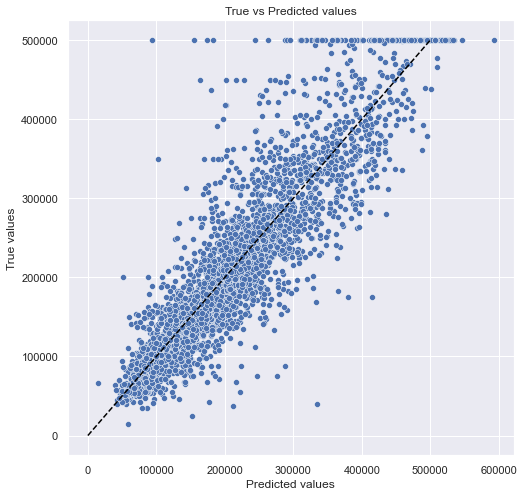

In [55]:
y_pred_test = model.predict(X_test)
evaluate_preds(y_test['median_house_value'], y_pred_test)

In [56]:
# 0.81270 после первого пункта
# 0.81516 после добавления второго
# 0.81516 после добавления третьего
# 0.81495 после добвления четвертого
# 0.82303 после добавления пятого
# 0.82725 после удаления колонок households and total-bedrooms
# 0.82867 при max_depth=13
# 0.83167 при добавлении distance

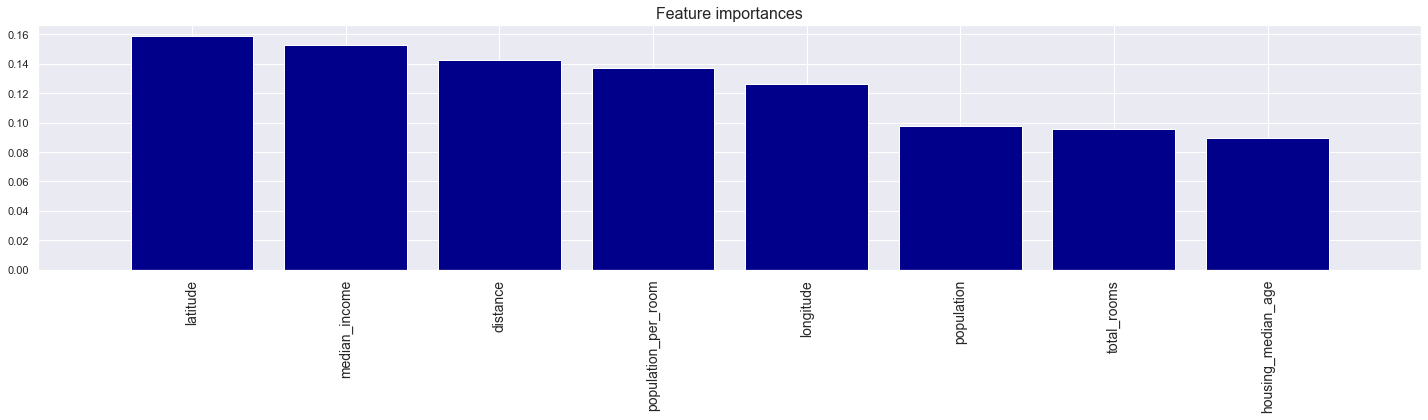

In [57]:
plot_feature_importances(importances = model.feature_importances_, X=X)

## Учим финальную модель

In [58]:
model_lgbm_f = LGBMRegressor(max_depth=13,
                             n_estimators=250,
                             random_state=42)
model_lgbm_f.fit(X, y)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


LGBMRegressor(max_depth=13, n_estimators=250, random_state=42)

In [59]:
y_pred_test = model_lgbm_f.predict(X_final)

In [60]:
y_pred_df = pd.DataFrame(y_pred_test, columns=['median_house_value'])

In [61]:
y_pred_df

,median_house_value
0,421997.956783
1,297890.741572
2,216628.640200
3,225503.756158
4,160797.279521
...,...
6807,114579.258953
6808,102186.834016
6809,89847.712094
6810,85771.659180


In [62]:
X_final.index

Int64Index([    0,     3,     5,     6,     8,    14,    17,    19,    29,
               30,
            ...
            20610, 20611, 20612, 20614, 20617, 20627, 20628, 20633, 20635,
            20638],
           dtype='int64', name='Id ', length=6812)

In [ ]:
filename = '201126_Lukash_1.csv'
y_pred_df.to_csv(filename, index=None)